In [1]:
import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

In [2]:
import SSM
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

In [3]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns

import scipy
import pyarrow

import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

In [4]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [5]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

(400.0, 600.0)

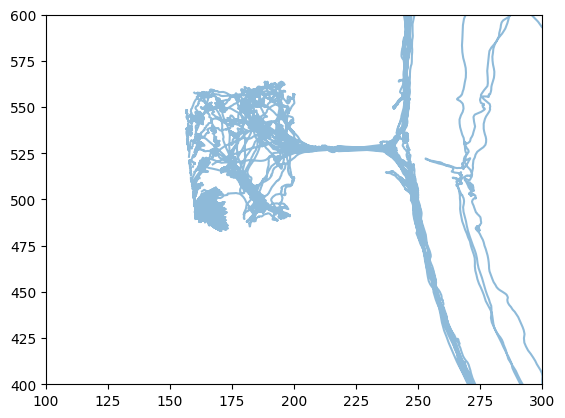

In [7]:
'''# Create some plots

# Plot _ hours of position activity
sub_start, sub_end = pd.Timestamp("2022-05-26 09:00:00"), pd.Timestamp("2022-05-26 10:00:00")
mouse_pos_sub = mouse_pos = api.load(root, exp02.CameraTop.Position, start=sub_start, end=sub_end)
fig, ax = plt.subplots(1, 1)
ax.plot(mouse_pos_sub.x, mouse_pos_sub.y, alpha=0.5)

# Overlay mouse position as trajectories around a few pellet deliveries
pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=sub_start, end=sub_end)
pellets_patch1 = pellets_patch1.iloc[0:5]
for pellet in pellets_patch1.itertuples():
    before = pellet.Index - pd.to_timedelta(10, 's')  # get the previous 10 seconds
    path = mouse_pos_sub.loc[before:pellet.Index]   # get position data in the time before pellet delivery
    ax.plot(path.x, path.y)
ax.set_xlim(100,300)
ax.set_ylim(400,600)'''

In [5]:
def PlotStates(hmm_z, mouse_pos, N):
    color_names = ["blue","red","yellow", "green","brown","purple","orange", "black"]
    colors = sns.xkcd_palette(color_names[0:N])
    cmap = gradient_cmap(colors)

    times = pd.to_datetime(mouse_pos.index)
    numerical_times = (times - times[0]).total_seconds().values
    states_array = hmm_z.reshape(1, -1)
    
    fig, axs = plt.subplots(1, 1, figsize=(35, 4))
    extent = [numerical_times[0], numerical_times[-1], 0, 1]
    cax = axs.imshow(states_array, aspect="auto", cmap=cmap, vmin=0, vmax=N-1, extent=extent)
    
    axs.set_xlabel('Time')
    axs.set_xticks(numerical_times[::len(numerical_times)//10])
    axs.set_xticklabels([time.strftime('%H:%M:%S') for time in times[::len(times)//10]], rotation=45, ha='right')
    
    axs.set_ylabel("States")
    axs.set_yticks([])

    cbar = fig.colorbar(cax, ax=axs, orientation='vertical')
    cbar.set_ticks(np.arange(0, N))
    cbar.set_ticklabels([f'State {val}' for val in np.arange(0, N)])
    
    plt.tight_layout()
    plt.show()

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Long Sessions

LongSession0


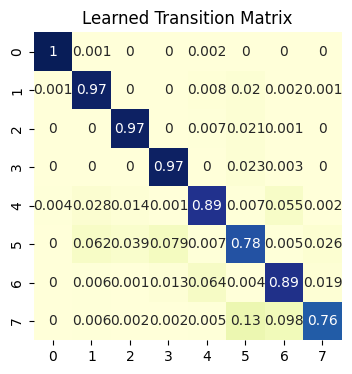

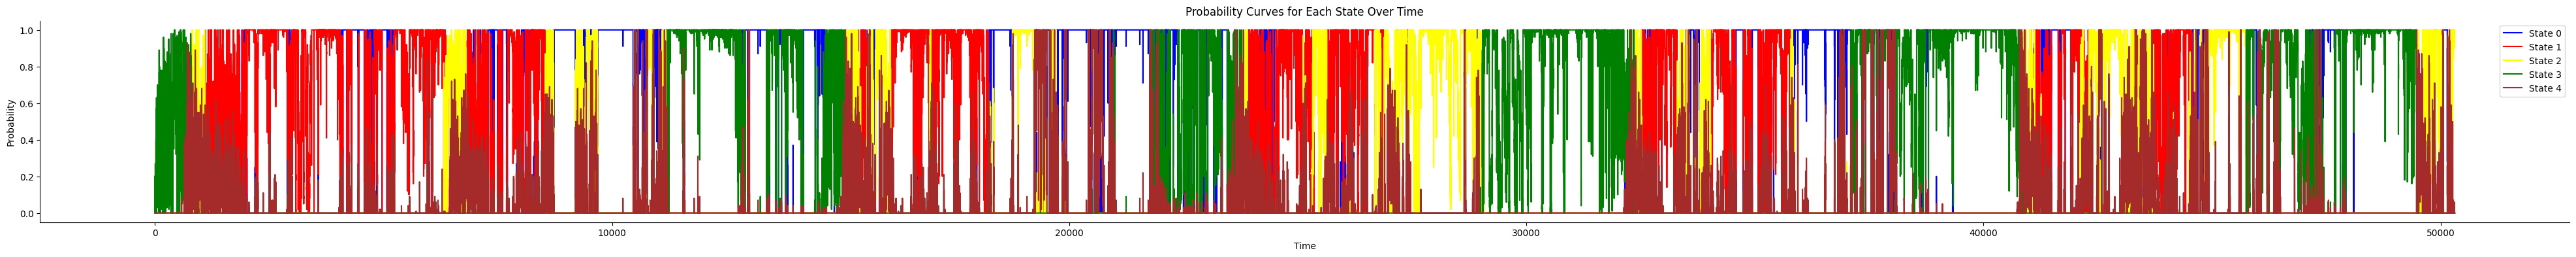

LongSession1


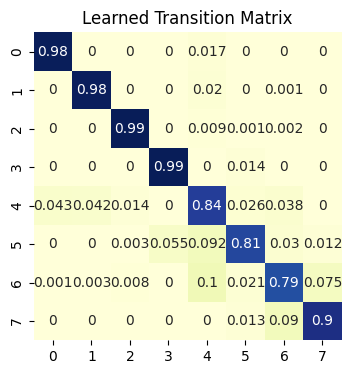

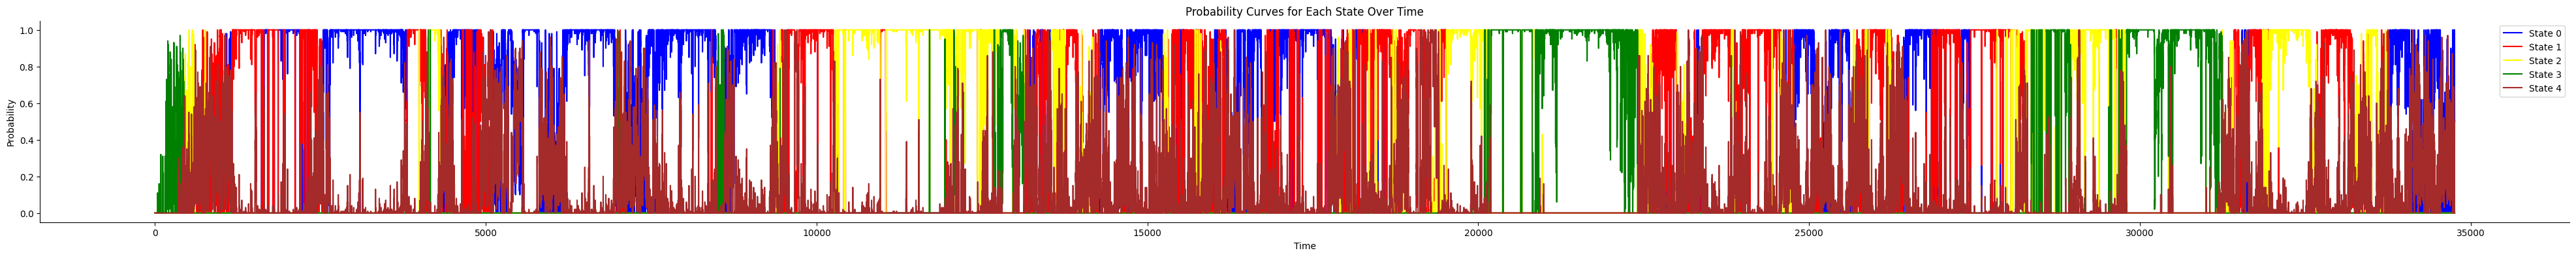

LongSession2


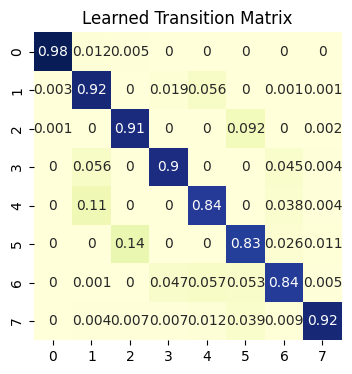

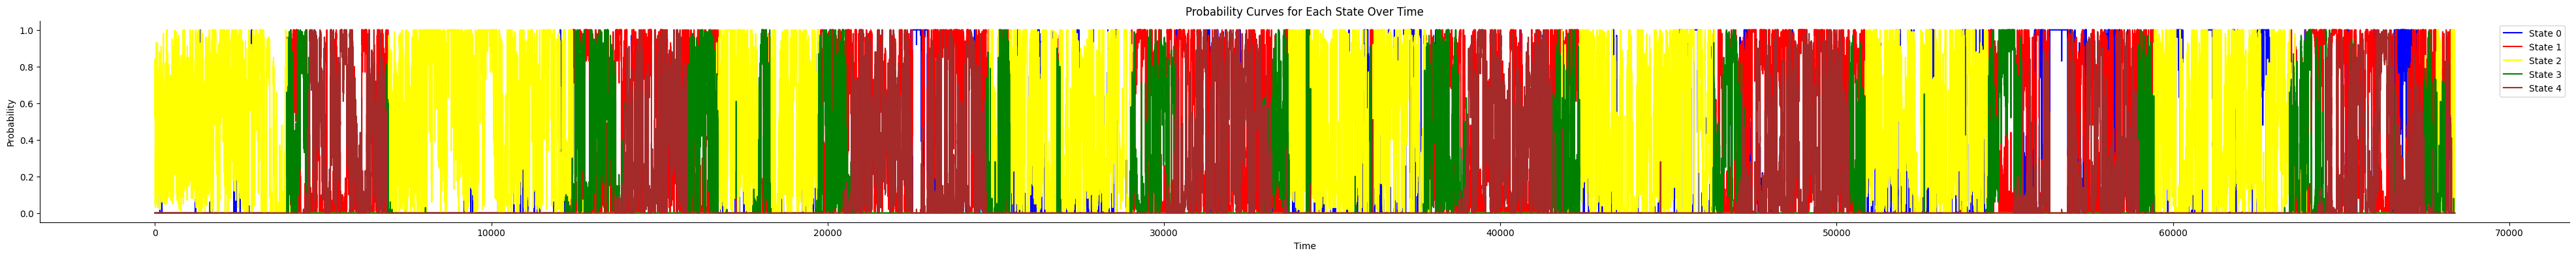

In [7]:
color_names = ["blue","red","yellow", "green","brown","purple","orange","black"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

N = 8

for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j > 2: continue
    title = 'LongSession'+str(j)
    print(title)
    
    transition_mat =  np.load(title+"Transition_3.npy", allow_pickle=True)
    annot_array = np.array([[round(item, 3) for item in row] for row in transition_mat])
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(transition_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs.set_title("Learned Transition Matrix")
    plt.show() 
    
    states = np.load(title+"States_3.npy", allow_pickle = True)

    num_bins = len(states) // 100

    # Reshape the array to segment into bins of 100, ignoring the remainder for now
    bins = states[:num_bins * 100].reshape(-1, 100)

    # Initialize a dictionary to hold the probabilities for each state
    state_probabilities = {state: [] for state in np.unique(states)}

    # Calculate the probabilities for each bin
    for bin in bins:
        # Count the occurrences of each state in the bin
        counts = np.bincount(bin, minlength=len(state_probabilities))
        
        # Calculate the probability for each state and update the dictionary
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / 100.0)

    # If you have a remainder, calculate its state probabilities separately
    remainder = len(states) % 100
    if remainder != 0:
        last_bin = states[-remainder:]
        counts = np.bincount(last_bin, minlength=len(state_probabilities))
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / remainder)
    
    fig, axs = plt.subplots(1,1,figsize = (50, 4))
    for state in range(5): 
        axs.plot(state_probabilities[state], label=f'State {state}', color = color_names[state])

    axs.set_xlabel('Time')
    axs.set_ylabel('Probability')
    axs.set_title('Probability Curves for Each State Over Time')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.legend()
    plt.show()

LongSession0


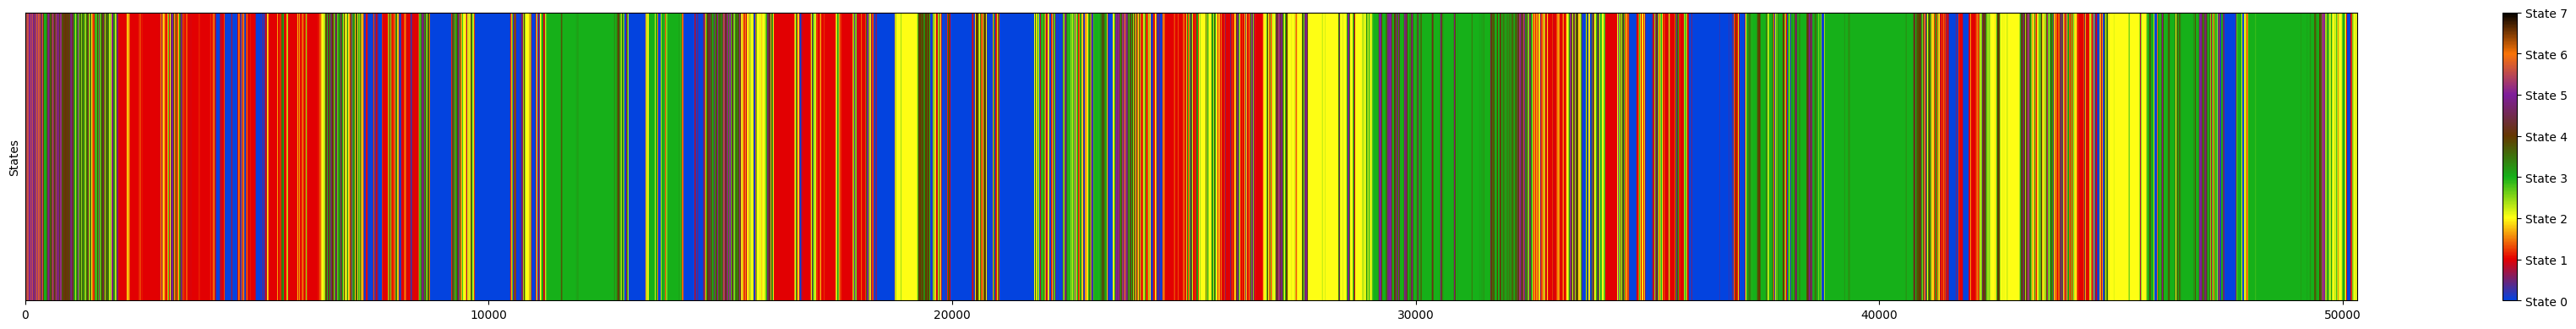

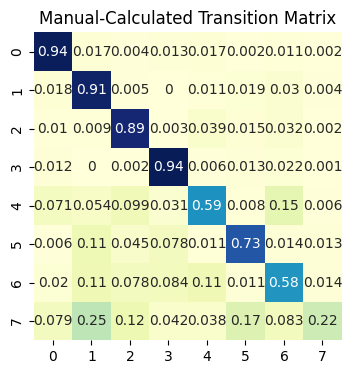

LongSession1


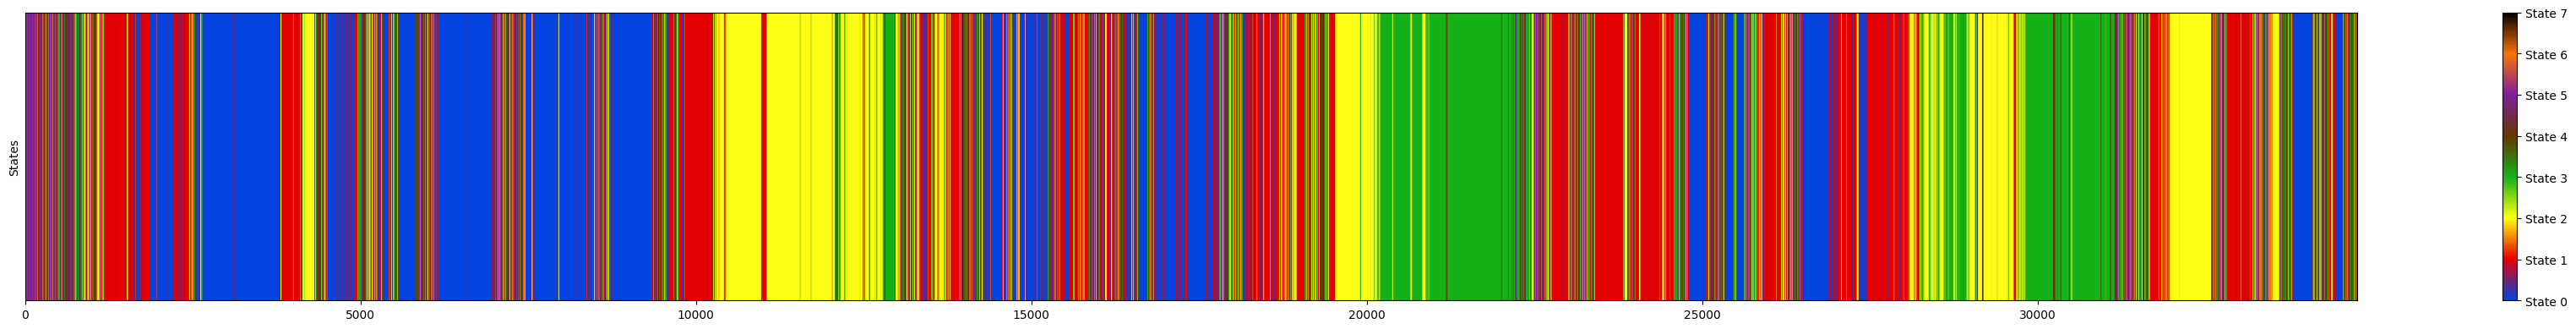

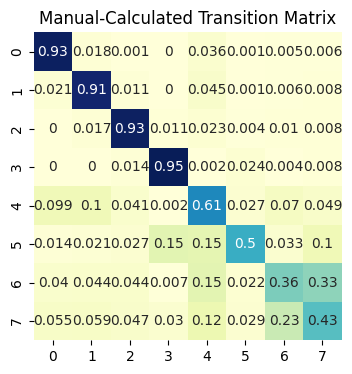

LongSession2


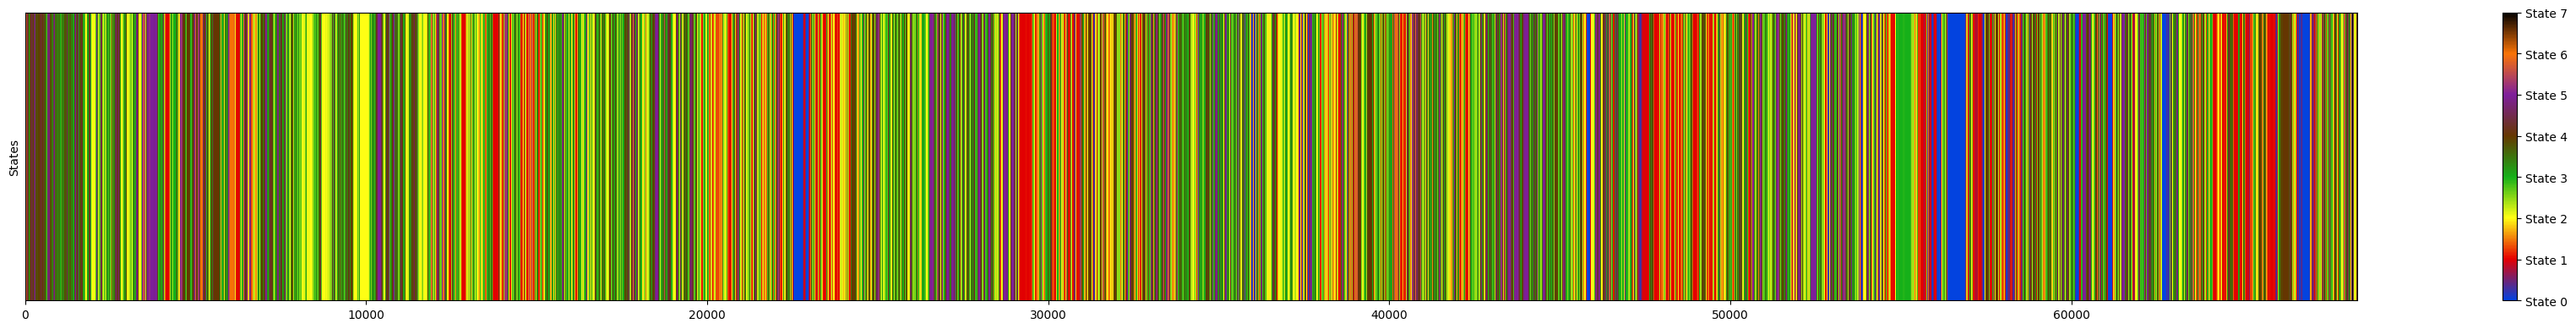

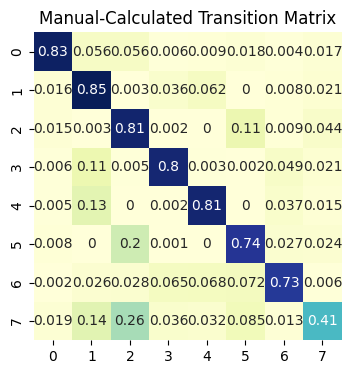

In [9]:
N = 8
for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j > 2: continue
    title = 'LongSession'+str(j)
    print(title)

    states = np.load(title+"States_3.npy", allow_pickle = True)

    num_bins = len(states) // 100
    bins = states[:num_bins * 100].reshape(-1, 100)
    state_probabilities = {state: [] for state in np.unique(states)}

    for bin in bins:
        counts = np.bincount(bin, minlength=len(state_probabilities))

        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / 100.0)
            
    remainder = len(states) % 100
    if remainder != 0:
        last_bin = states[-remainder:]
        counts = np.bincount(last_bin, minlength=len(state_probabilities))
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / remainder)
    
    x = np.array([list(state_probabilities[i]) for i in range(N)])

    states_ = []
    for i in range(len(x[0])):
        current_state = x.T[i]
        states_.append(np.argmax(current_state))


    fig, axs = plt.subplots(1, 1, figsize=(35, 4))
    cax = axs.imshow(np.array(states_).reshape(1,-1), aspect="auto", cmap=cmap, vmin=0, vmax=np.max(states_))
    axs.set_ylabel("States")
    axs.set_yticks([])
    cbar = fig.colorbar(cax, ax=axs, orientation='vertical')
    cbar.set_ticks(np.arange(0, np.max(states_) + 1))
    cbar.set_ticklabels([f'State {val}' for val in np.arange(0, np.max(states_) + 1)])   
    plt.tight_layout()
    plt.show()
    
    manual_trans_mat = np.zeros((N,N))
    for i in range(1,len(states_)): manual_trans_mat[states_[i-1]][states_[i]] += 1

    for i in range(N): manual_trans_mat[i] = manual_trans_mat[i]/np.sum(manual_trans_mat[i])

    annot_array = np.array([[round(item, 3) for item in row] for row in manual_trans_mat])
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(manual_trans_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs.set_title("Manual-Calculated Transition Matrix")
    plt.show()

## Session 0

In [10]:
N = 8
for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j > 0: continue
    title = 'LongSession'+str(j)
    print(title)
                                
    start, end = session.enter, session.exit
    mouse = api.load(root, exp02.CameraTop.Position, start=start, end=end)
            
    mouse = kinematics.ProcessRawData(mouse, root, start, end)
            
    patch.AddKinematics(title, mouse)
            
    mouse_pos_subs = patch.SeparateDF(mouse)

    dfs = []
    for mouse_pos_sub in mouse_pos_subs:
        mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_speed'] <= 2000]
        mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_acceleration'] <= 60000]
        mouse_pos_sub = patch.DeleteRows(mouse_pos_sub)

        mouse_pos_sub = mouse_pos_sub.loc[:,['x']]
                
        dfs.append(mouse_pos_sub)

    mouse_pos = dfs[0]
    for df in dfs[1:]: mouse_pos = mouse_pos.add(df, fill_value=0)
    
    states = np.load(title+"States_3.npy", allow_pickle = True)
    mouse_pos['states'] = pd.Series(states, index=mouse_pos.index)
    

    grouped = mouse_pos.groupby([pd.Grouper(freq='10S'), 'states']).size()
    prob = grouped.groupby(level=0).apply(lambda g: g / g.sum())
    states_prob = prob.unstack(level=-1).fillna(0)
    states_prob.index = states_prob.index.get_level_values(0)
    
    for i in range(N):
        if i not in states_prob.columns: states_prob[i] = 0
    
    x = np.array([np.array(states_prob[i].to_list()) for i in range(N)])

    states_ = []
    for i in range(len(x[0])):
        current_state = x.T[i]
        states_.append(np.argmax(current_state))
    
    PlotStates(np.array(states_), states_prob, N=7)

LongSession0


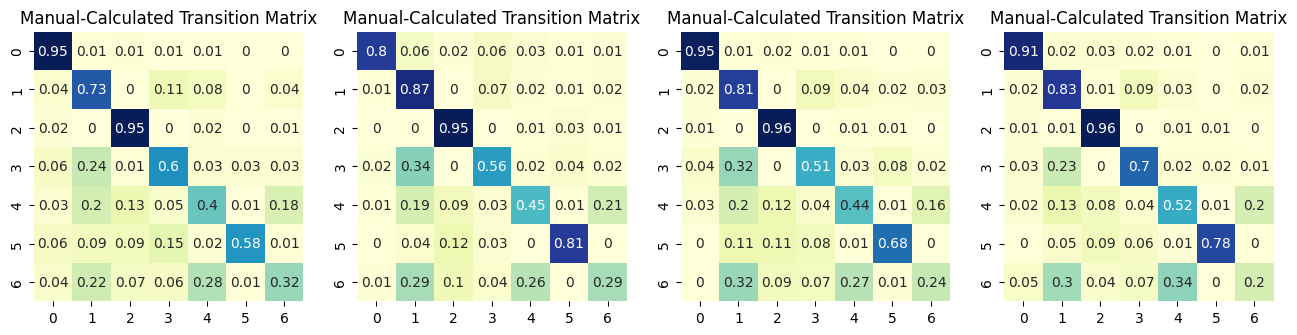

In [13]:
START = ['2022-03-30 07:00:00','2022-04-01 07:00:00','2022-04-02 07:00:00','2022-04-03 07:00:00']
END = ['2022-03-31 07:00:00','2022-04-02 07:00:00','2022-04-03 07:00:00','2022-04-04 07:00:00']
#states_prob['states'] = pd.Series(states_, index=states_prob.index)
fig, axs = plt.subplots(1,4, figsize=(16, 4))
for j in range(len(START)):
    start, end = pd.Timestamp(START[j]),pd.Timestamp(END[j])
    period_data = states_prob.loc[start:end]
    states_ = period_data['states'].to_numpy()
    
    manual_trans_mat = np.zeros((N,N))
    for i in range(1,len(states_)): manual_trans_mat[states_[i-1]][states_[i]] += 1
    for i in range(N): 
        if np.sum(manual_trans_mat[i]) != 0: manual_trans_mat[i] = manual_trans_mat[i]/np.sum(manual_trans_mat[i])

    annot_array = np.array([[round(item, 2) for item in row] for row in manual_trans_mat])
    
    sns.heatmap(manual_trans_mat, cmap='YlGnBu', ax = axs[j], square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs[j].set_title("Manual-Calculated Transition Matrix")
plt.show()